In [1]:
!pip install kaggle

In [2]:
!mkdir ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle competitions download ml-intensive-yandex-academy-autumn-2024

100% 7.90G/7.90G [00:37<00:00, 56.5MB/s]
100% 7.90G/7.90G [00:37<00:00, 229MB/s] 


In [6]:
!mkdir data

In [7]:
!unzip ml-intensive-yandex-academy-autumn-2024.zip -d data

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: data/human_poses_data/img_train/3413.jpg  
  inflating: data/human_poses_data/img_train/3414.jpg  
  inflating: data/human_poses_data/img_train/3417.jpg  
  inflating: data/human_poses_data/img_train/3418.jpg  
  inflating: data/human_poses_data/img_train/3420.jpg  
  inflating: data/human_poses_data/img_train/3421.jpg  
  inflating: data/human_poses_data/img_train/3422.jpg  
  inflating: data/human_poses_data/img_train/3423.jpg  
  inflating: data/human_poses_data/img_train/3424.jpg  
  inflating: data/human_poses_data/img_train/3425.jpg  
  inflating: data/human_poses_data/img_train/3427.jpg  
  inflating: data/human_poses_data/img_train/3428.jpg  
  inflating: data/human_poses_data/img_train/3429.jpg  
  inflating: data/human_poses_data/img_train/3431.jpg  
  inflating: data/human_poses_data/img_train/3432.jpg  
  inflating: data/human_poses_data/img_train/3434.jpg  
  inflating: data/human_poses_data/i

In [9]:
!pip install torchsummary

In [64]:
!pip install pytorch-ignite

In [1]:
import sys
import os

import torch
import csv
import numpy as np
import matplotlib.pyplot as plt

from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
from PIL import Image
from torchsummary import summary
from ignite.engine import create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from ignite.engine import Events
from ignite.handlers.param_scheduler import ReduceLROnPlateauScheduler

/usr/local/lib/python3.10/dist-packages/torch_xla/__init__.py:253: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
PATH = 'data/human_poses_data/'
transforms = v2.Compose([v2.PILToTensor(),
                         v2.Resize(size=(640, 640)),
                         v2.ToDtype(torch.float32),
                         ])

In [4]:
def read_image(path):
    return Image.open(path)


def create_dataset(X_path):
    res = []
    ids = sorted(os.listdir(X_path), key=lambda x: int(x[:-4]))
    for i in ids:
        res.append(read_image(X_path + '/' + i))
    return res

In [5]:
X = create_dataset(PATH + 'img_train')

In [6]:
y = []
with open(PATH + 'train_answers.csv') as f:
    table = csv.reader(f)
    y = sorted([i for i in table][1:], key=lambda x: int(x[0]))

In [7]:
train_y = nn.functional.one_hot(torch.tensor([int(i[1]) for i in y]))

In [8]:
categories = []
with open(PATH + 'activity_categories.csv') as f:
    table = csv.reader(f)
    categories =[i for i in table][1:]

In [9]:
counts = [0] * len(categories)
for i in y:
    counts[int(i[1])] += 1
counts

[2512,
 135,
 530,
 1680,
 752,
 982,
 800,
 0,
 533,
 1223,
 390,
 528,
 469,
 442,
 228,
 0,
 753,
 0,
 410,
 0]

In [10]:
class CustomDataset(Dataset):
    def __init__(self, X, y, transforms):
        self.X = X
        self.y = torch.as_tensor(y, dtype=torch.float32)
        self.transforms = transforms

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.transforms(self.X[idx]), self.y[idx]

In [27]:
train_val_dataset = CustomDataset(X, train_y, transforms)
train, val = random_split(train_val_dataset, [0.8, 0.2])

In [12]:
len(train_val_dataset[1][1])

19

In [13]:
from IPython.display import clear_output

def show_train_plots(loss_hist, accuracy_hist):
    clear_output()

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.title('Train Loss')
    plt.plot(np.arange(len(loss_hist)), loss_hist)
    plt.yscale('log')
    plt.grid()

    plt.subplot(2, 2, 2)
    plt.title('Train Accuracy')
    plt.plot(np.arange(len(accuracy_hist)), accuracy_hist)
    plt.yscale('log')
    plt.grid()


def show_test_plots(loss_hist, accuracy_hist):
    plt.subplot(2, 2, 3)
    plt.title('Test Loss')
    plt.plot(np.arange(len(loss_hist)), loss_hist)
    plt.yscale('log')
    plt.grid()

    plt.subplot(2, 2, 4)
    plt.title('Test Accuracy')
    plt.plot(np.arange(len(accuracy_hist)), accuracy_hist)
    plt.yscale('log')
    plt.grid()

    plt.show()

In [14]:
class Trainer:
    def __init__(self, model, optimizer, loss_function, train_loader, valid_loader):
        self.trainer = create_supervised_trainer(model, optimizer, loss_function)
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.valid_loader = valid_loader

        self.metrics = {"accuracy": Accuracy(), "loss": Loss(loss_function)}

        self.train_evaluator = create_supervised_evaluator(model, metrics=self.metrics)
        self.valid_evaluator = create_supervised_evaluator(model, metrics=self.metrics)

        self.train_accuracy_hist = []
        self.train_loss_hist = []
        self.test_accuracy_hist = []
        self.test_loss_hist = []

        self.trainer.add_event_handler(Events.EPOCH_COMPLETED, self.compute_epoch_results)

        self.train_evaluator.add_event_handler(Events.EPOCH_COMPLETED, self.log_epoch_results, label="Train")
        self.valid_evaluator.add_event_handler(Events.EPOCH_COMPLETED, self.log_epoch_results, label="Valid")

        self.scheduler = ReduceLROnPlateauScheduler(optimizer, metric_name="loss", factor=0.5, patience=1, threshold=0.05)

        self.valid_evaluator.add_event_handler(Events.COMPLETED, self.scheduler)
        self.valid_evaluator.add_event_handler(Events.COMPLETED, self.print_lr)

    def compute_epoch_results(self, engine):
        self.train_evaluator.run(self.train_loader)
        self.valid_evaluator.run(self.valid_loader)

    def log_epoch_results(self, engine, label=""):
        if label == 'Train':
            self.train_accuracy_hist.append(engine.state.metrics['accuracy'])
            self.train_loss_hist.append(engine.state.metrics['loss'])
            show_train_plots(self.train_loss_hist, self.train_accuracy_hist)
        else:
            self.test_accuracy_hist.append(engine.state.metrics['accuracy'])
            self.test_loss_hist.append(engine.state.metrics['loss'])
            show_test_plots(self.test_loss_hist, self.test_accuracy_hist)
            result = ', '.join([f"{m} = {v}" for m, v in engine.state.metrics.items()])
            print(f"{label} Res:", result)

    def print_lr(self):
        for param_group in self.optimizer.param_groups:
            print(f"Optimizer learning rate = {param_group['lr']}")

    def train(self, epochs):
        self.trainer.run(self.train_loader, epochs)

In [15]:
class LinearNeuralNetwork(nn.Module):
    def __init__(self, img_shape=(3, 640, 640)):
        super().__init__()
        self.linear = nn.Sequential(
            nn.Flatten(-3),
            nn.Linear(np.prod(img_shape), 500),
            nn.ReLU(),
            nn.Linear(500, 100),
            nn.ReLU(),
            nn.Linear(100, 19),
            nn.Softmax(),
        )

    def forward(self, x):
        return self.linear(x)

In [16]:
model = LinearNeuralNetwork().to(device)

summary(model, (3, 640, 640))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1              [-1, 1228800]               0
            Linear-2                  [-1, 500]     614,400,500
              ReLU-3                  [-1, 500]               0
            Linear-4                  [-1, 100]          50,100
              ReLU-5                  [-1, 100]               0
            Linear-6                   [-1, 19]           1,919
           Softmax-7                   [-1, 19]               0
Total params: 614,452,519
Trainable params: 614,452,519
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 4.69
Forward/backward pass size (MB): 9.38
Params size (MB): 2343.95
Estimated Total Size (MB): 2358.02
----------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1844: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return inner()


In [17]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss = nn.CrossEntropyLoss()

In [18]:
from tqdm import tqdm


def run_epoch(model, opt, loss, dataloader, is_train=True):
    model.train(is_train)
    total_loss = 0.0
    with torch.set_grad_enabled(is_train):
        for x, y in tqdm(dataloader):
            x = x.to(device)
            l = loss(model(x), y)
            if (is_train):
                opt.zero_grad()
                l.backward()
                opt.step()
            total_loss += l.item()
    return total_loss / len(dataloader.dataset)

In [19]:
def plot_loss(loss, title, num_epochs):
    plt.title(title)
    plt.plot(loss)
    plt.grid()
    plt.xticks(np.arange(num_epochs))

def plot_losses(train, val, num_epochs):
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    plot_loss(train, f'Train Loss = {train[-1]}', num_epochs)
    plt.subplot(1, 2, 2)
    plot_loss(val, f'Val Loss = {val[-1]}', num_epochs)
    plt.show()

In [20]:
from IPython.display import clear_output

def run_train_loop(model, opt, loss, train_loader, val_loader, num_epochs):
    train_hist = []
    val_hist = []
    for e in range(num_epochs):
        print("Training...")
        train_loss = run_epoch(model, opt, loss, train_loader)
        train_hist.append(train_loss)
        print("Validating...")
        val_loss = run_epoch(model, opt, loss, val_loader, is_train=False)
        val_hist.append(val_loss)
        clear_output()
        plot_losses(train_hist, val_hist, num_epochs)

In [28]:
batch_size = 64

train_loader = DataLoader(train, batch_size)
val_loader = DataLoader(val, batch_size)

trainer = Trainer(model, opt, loss, train_loader, val_loader)

In [ ]:
trainer.train(2)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [47]:
batch_size = 64
num_epochs = 2

train_loader = DataLoader(train, batch_size)
val_loader = DataLoader(val, batch_size)

trainer = Trainer(model, opt, loss, train_loader, val_loader)

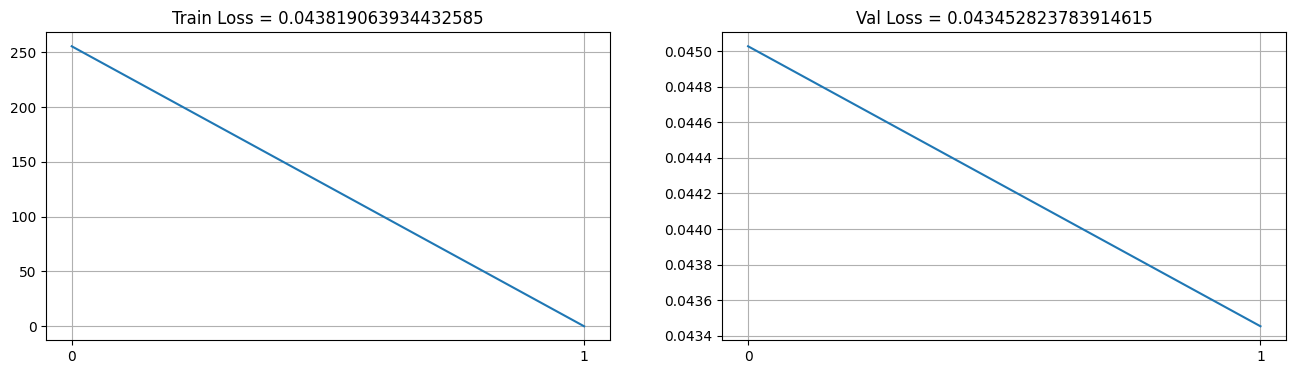

In [28]:
batch_size = 64
num_epochs = 2

train_loader = DataLoader(train, batch_size)
val_loader = DataLoader(val, batch_size)

run_train_loop(model, opt, loss, train_loader, val_loader, num_epochs)

In [55]:
print(model(train[1][0]))
print(train[1][1])

tensor([4.6142e-07, 3.0110e-11, 1.9579e-09, 1.4705e-07, 4.7564e-12, 5.6917e-09,
        1.5128e-13, 7.7756e-09, 5.1965e-14, 1.8882e-07, 4.6266e-17, 5.5938e-10,
        3.2748e-08, 8.9859e-12, 6.2376e-09, 4.8707e-11, 1.0000e+00, 1.0746e-17,
        3.9639e-10], grad_fn=<SoftmaxBackward0>)
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])
